In [1]:
import math
from math import cos, log, pi, sin, sqrt

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix

plt.rcParams.update({"font.size": 16})

In [2]:
# Utils
def BoxMuller(mean, var):
    # y = x*sigma + var
    # => y = sqrt(-2*ln(a)) * cos(2*pi*b) * sigma + mu
    a = np.random.uniform()
    b = np.random.uniform()
    sigma = sqrt(var)

    return sqrt(-2 * log(a)) * sin(2 * pi * b) * sigma + mean


def buildFeatureMat(mean, var, N):
    # [1 x y]
    generate_x = []
    generate_y = []
    init_x = BoxMuller(mean, var)
    init_y = BoxMuller(mean, var)
    generate_x.append(init_x)
    generate_y.append(init_y)
    feature = np.array([1, init_x, init_y])

    for _ in range(N - 1):
        new_x = BoxMuller(mean, var)
        new_y = BoxMuller(mean, var)
        generate_x.append(new_x)
        generate_y.append(new_y)
        newdata = np.array([1, new_x, new_y])
        feature = np.vstack((feature, newdata))
    return feature, generate_x, generate_y


def safe_ln(x):
    mask = np.ma.log(x)
    #mask = mask.filled(-math.inf)
    mask = mask.filled(0)
    return mask

In [3]:
# Part 1: Logistic Regression
def sigmoid(x):
    # vectorized sigmoid
    return 1 / (1 + np.exp(-x))


def predict(feature, weight):
    return sigmoid(feature.dot(weight))


# instead of using LSE, we use Cross Entropy as loss function here
def logloss(feature, label, w):
    """
    N = 50+50 = 100
    Feature matrix: 100 x 3
    label(0 or 1): 100 x 1
    weights: 3 x 1
    h(prediction): 100 x 1
    """
    h = predict(feature, w)
    m = len(label)
    cost = np.asscalar(np.dot(-label.T, safe_ln(h)) - np.dot((1 - label).T, safe_ln(1 - h)))
    cost = cost / m
    return cost


def updateW(feature, label, w, learn_rate):
    """
    Feature: 100 x 3
    label: 100 x 1
    weights: 3 x 1
    learning rate: scalar
    """
    h = predict(feature, w)  # 100 x 1
    gradient = np.dot((h - label).T, feature)  # 1 x 100 x 100 x 3 => 1 x 3

    return w - learn_rate * gradient.T


def GD(feature, label, lr=1, iters=1000):
    # initialize weights:
    cost = 0
    w = np.zeros((3, 1))
    cost_log = []
    for i in range(iters):
        prev_cost = cost
        w = updateW(feature, label, w, lr)
        cost = logloss(feature, label, w)
        if i >= 100 and abs(cost - prev_cost) <= 1e-2:
            break
        cost_log.append(cost)
    return w, cost_log


def genMatD(d):
    D = np.eye(len(d))
    for i in range(len(d)):
        D[i, i] = d[i]
    return D


def Newton(feature, label, lr=1, iters=1000):
    """
    weight: 3 x 1
    Feature: 100 x 3
    label: 100 x 1
    Hessian: 3 x 3
    gradient: 3 x 1
    """
    w = np.zeros((3, 1))
    cost = 0

    for i in range(iters):
        prev_cost = cost
        h = predict(feature, w)

        # Calculate Gradient
        gradient = np.dot(feature.T, (h - label))

        # Calculate Hessian
        D = genMatD(np.dot(genMatD(h), 1 - h))
        Hessian = np.dot(feature.T.dot(D), feature)

        # Update weight
        try:
            delta = np.linalg.inv(Hessian).dot(gradient)
        except:
            delta = gradient
        w = w - delta * lr

        cost = logloss(feature, label, w)
        if i >= 100 and abs(cost - prev_cost) <= 1e-2:
            break

    return w

In [4]:
def LogisticReg(m1, v1, m2, v2, N, a=1):
    # Generate data
    D1_feature, D1_x, D1_y = buildFeatureMat(m1, v1, N)
    D2_feature, D2_x, D2_y = buildFeatureMat(m2, v2, N)
    Data_x = D1_x + D2_x
    Data_y = D1_y + D2_y
    Data_feature = np.vstack((D1_feature, D2_feature))
    D1_label = np.zeros((N, 1))
    D2_label = np.ones((N, 1))
    Data_label = np.vstack((D1_label, D2_label))

    # Visualize and output result
    # Ground Truth
    ground_truth = Data_label.flatten()
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 3, 1)
    plt.title("Ground Truth")
    for x, y in zip(D1_x, D1_y):
        plt.scatter(x, y, c="red")
    for x, y in zip(D2_x, D2_y):
        plt.scatter(x, y, c="blue")

    # GD:
    print("Gradient descent:\n")
    weight, cost_log = GD(Data_feature, Data_label, lr=a)

    print("w:")
    for w in weight:
        print(" %10f" % w)

    # Classify predict result
    pred_label = Data_feature.dot(weight)
    pred_label = sigmoid(pred_label.flatten())
    pred_label[pred_label >= 0.5] = 1
    pred_label[pred_label < 0.5] = 0

    # Print cm and specificity, sensitivity
    print("\nConfusion Matrix:")
    cm = confusion_matrix(ground_truth, pred_label)
    print(cm)
    print("\nSensitivity (Successfully predict cluster 1):", cm[0, 0] / (cm[0, 0] + cm[0, 1]))
    print("Specificity (Successfully predict cluster 2):", cm[1, 1] / (cm[1, 0] + cm[1, 1]))

    # plot predict result
    plt.subplot(1, 3, 2)
    plt.title("Gradient Descent")

    for i in range(len(Data_x)):
        if pred_label[i] == 0:
            plt.scatter(Data_x[i], Data_y[i], c="red", label="cluster 1")
        else:
            plt.scatter(Data_x[i], Data_y[i], c="blue", label="cluster 2")

    print("-------------------------------------")

    # Newton's
    print("Newton's method:")
    newton_weight = Newton(Data_feature, Data_label, lr=a)

    print("w:")
    for w in newton_weight:
        print(" %10f" % w)

    # Classify predict result
    new_pred_label = Data_feature.dot(newton_weight)
    new_pred_label = sigmoid(new_pred_label.flatten())
    new_pred_label[new_pred_label >= 0.5] = 1
    new_pred_label[new_pred_label < 0.5] = 0

    # Print cm and specificity, sensitivity
    print("\nConfusion Matrix:")
    cm = confusion_matrix(ground_truth, new_pred_label)
    print(cm)
    print("\nSensitivity (Successfully predict cluster 1):", cm[0, 0] / (cm[0, 0] + cm[0, 1]))
    print("Specificity (Successfully predict cluster 2):", cm[1, 1] / (cm[1, 0] + cm[1, 1]))

    # Plot predict result
    plt.subplot(1, 3, 3)
    plt.title("Newton's method")
    for i in range(len(Data_x)):
        if new_pred_label[i] == 0:
            plt.scatter(Data_x[i], Data_y[i], c="red", label="cluster 1")
        else:
            plt.scatter(Data_x[i], Data_y[i], c="blue", label="cluster 2")

Gradient descent:

w:
 -154.852230
  11.769337
  28.917004

Confusion Matrix:
[[50  0]
 [ 0 50]]

Sensitivity (Successfully predict cluster 1): 1.0
Specificity (Successfully predict cluster 2): 1.0
-------------------------------------
Newton's method:
w:
 -163.704057
   9.577891
  14.291179

Confusion Matrix:
[[50  0]
 [ 0 50]]

Sensitivity (Successfully predict cluster 1): 1.0
Specificity (Successfully predict cluster 2): 1.0


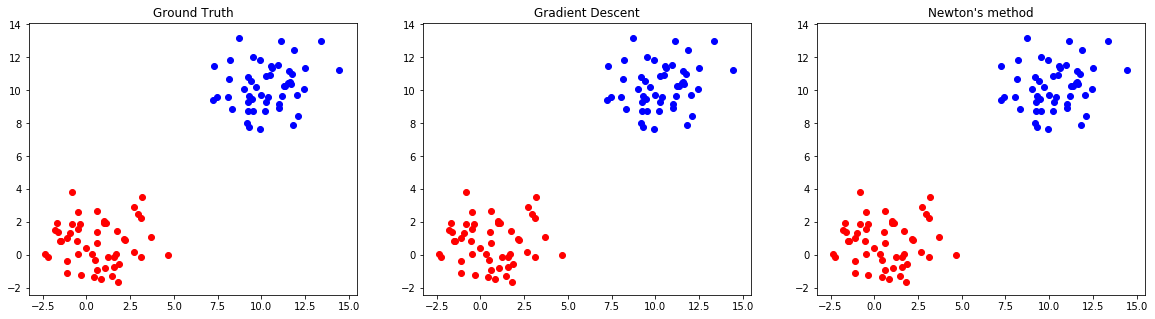

In [7]:
# Case 1: N=50, mx1=my1=1, mx2=my2=10, vx1=vy1=vx2=vy2=2
LogisticReg(1, 2, 10, 2, 50)

Gradient descent:

w:
 -153.985011
  24.285714
  32.417383

Confusion Matrix:
[[50  0]
 [21 29]]

Sensitivity (Successfully predict cluster 1): 1.0
Specificity (Successfully predict cluster 2): 0.58
-------------------------------------
Newton's method:
w:
  -3.313832
   0.986784
   0.911637

Confusion Matrix:
[[42  8]
 [11 39]]

Sensitivity (Successfully predict cluster 1): 0.84
Specificity (Successfully predict cluster 2): 0.78


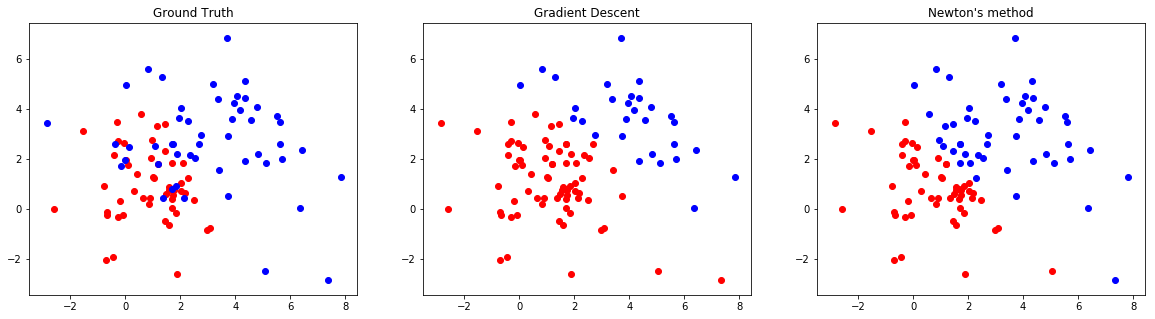

In [8]:
# Case 2: N=50, mx1=my1=1, mx2=my2=3, vx1=vy1=2, vx2=vy2=4
LogisticReg(1, 2, 3, 4, 50)